In [102]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [103]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [104]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

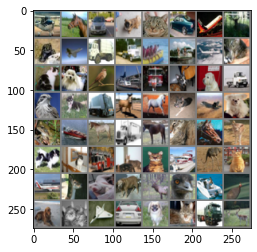

plane horse car   dog   cat   car   plane deer  frog  plane truck truck ship  ship  plane cat   cat   dog   bird  ship  truck cat   dog   truck bird  dog   truck horse horse dog   plane dog   frog  ship  horse truck horse cat   horse deer  dog   cat   truck cat   cat   ship  bird  cat   plane deer  dog   dog   deer  bird  ship  bird  dog   cat   plane car   dog   cat   truck deer 


In [105]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [106]:
class MyAE(nn.Module):
    '''
     net = MyAE(latent_dim=64, ch_size=3)    
     Inputs:
       latent_dim     number of nodes in embedding (latent) layer.
       ch_size        number of input channels.r
    '''
    def __init__(self, latent_dim=64, ch_size=3):
        self.latent_dim = latent_dim
        self.channels = ch_size
        self.losses = []
        super().__init__()
        
        # Encode
        c_hid = 64
        self.Encoder = nn.Sequential(
            nn.Conv2d(self.channels, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Flatten(),
            nn.Linear(2*16*c_hid, self.latent_dim)
        )
        
        # Linear Compression
        self.Linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            nn.Sigmoid()
        )
        
        # Decode
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(c_hid, self.channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh()
        )
 
    def forward(self, x):
        
        # Forward pass
        h = self.Encoder(x)
        h = self.Linear(h)
        h_flat = h.reshape(h.shape[0], -1, 4, 4)
        y = self.Decoder(h_flat)
        return y

    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in range(epochs):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                #x = x.to(device)   # for use with a GPU
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))

        plt.figure(figsize=(6,4))
        plt.plot(self.losses); plt.yscale('log');

In [107]:
net = MyAE(latent_dim=128, ch_size=3)
outAE = net(images)
outAE.shape

torch.Size([64, 3, 32, 32])

In [108]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    losses =[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/2000 :.3f}')
            losses.append(running_loss / 2000)
            running_loss = 0.0
print('Finished Training')

In [109]:
# Uncomment the following line if you want to save your network.
#torch.save(net.to('cpu'), 'CIFAR_AE_128.pt')

# The corresponding code to reload the network is below.
net = torch.load('CIFAR_AE_128.pt')
# Remember to send it to the GPU, if you're using one.
#net.to(device)

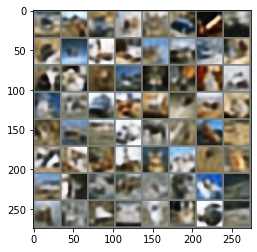

In [110]:
outAE = net(images)
imshow(torchvision.utils.make_grid(outAE))

In [130]:
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

1194243


In [127]:
for k in net.parameters():
    if k.requires_grad:
        print(sum(k.numel()))

TypeError: 'int' object is not iterable

In [ ]:
##*******************************************************************

In [54]:
images.shape, net.Encoder(images).shape, outAE.shape

(torch.Size([64, 3, 32, 32]),
 torch.Size([64, 64]),
 torch.Size([64, 3, 32, 32]))

In [93]:
def embedding(model, data_loader):
    """ Encodes all the images in the data loader """
    images = []
    embedded = []
    labels =[]
    for input, label in (data_loader):
        #print(input.shape)
        with torch.no_grad():
            z = model.Encoder(input)
        images.append(input)
        embedded.append(z)
        print(z.shape)
        labels.append(label)
    return (torch.cat(images, dim=0), torch.cat(embedded, dim=0),torch.cat(labels, dim =0))

In [94]:
train_embeds = embedding(net, trainloader)
test_embeds = embedding(net, testloader)

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([16, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size

In [95]:
train_embeds[1].shape

torch.Size([50000, 128])

In [74]:
def find_similar_images(distance_type, query_img, query_class, query_z, key_embeds, K=5):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """

    print('You have selected an image of the ' + str(query_class) + ' class')
    print('Selected distance type is: '+ distance_type)
    
    if distance_type == 'Euclidean':
       print(query_z[None,:].shape)
       distance = torch.cdist(query_z[None,:], key_embeds[1], p=2)

    if distance_type == 'Cosine':
      cos = nn.CosineSimilarity(dim=1, eps=1e-9)
      distance = cos(query_z[None,:],  key_embeds[1])

    if distance_type == 'Pairwise':
      pair = nn.PairwiseDistance(p =2)
      distance = pair(query_z[None,:],  key_embeds[1])
      
    distance = distance.squeeze(dim=0)
    distance, indices = torch.sort(distance)
    print(indices)
    print("Distances")
    print(distance.shape)


    
    input_image = torch.cat([query_img[None]], dim =0)
    grid_input = torchvision.utils.make_grid(input_image, nrow=1, normalize=True, range=(-1,1))
    print('Selected image')
    grid_input = grid_input.permute(1, 2, 0)
    plt.figure(figsize=(1.5,1.5))
    plt.axis('off')
    plt.imshow(grid_input)
    plt.show()
    print('Similar images are:')
    imgs_to_display = torch.cat([key_embeds[0][indices[:K]]], dim=0)
    index = indices[:K]
    print(imgs_to_display.shape)
    print(index)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(9,2))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    c = []
#     for i in index:
#       c.append(classes[train_embeds[2][i]])
#     count =0
#     for i in c:
#       if str(i) == query_class:
#         count +=1 
#     print(str(count) +' out of ' + str(K) + ' images were in the same group')

In [77]:
test_embeds[0][rand_index[0]].shape

torch.Size([3, 32, 32])

You have selected an image of the cat class
Selected distance type is: Euclidean
torch.Size([1, 64])
tensor([21463, 48670,  4314,  ..., 35827, 10449, 20585])
Distances
torch.Size([50000])
Selected image


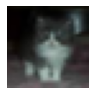

Similar images are:
torch.Size([5, 3, 32, 32])
tensor([21463, 48670,  4314,  2766, 31109])


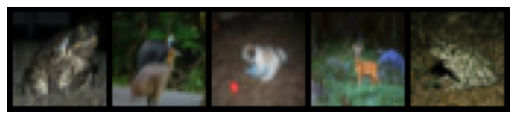

In [75]:
#select a random image in the test set
rand_index = np.random.randint(0, len(test_embeds[0]), 1)
find_similar_images('Euclidean', test_embeds[0][rand_index[0]], classes[test_embeds[2][rand_index[0]]], test_embeds[1][rand_index[0]], key_embeds=train_embeds)

In [76]:
array_2 = np.load('genImage.npy')
searchdata = torch.tensor(array_2)

In [60]:
searchZ = net.Encoder(images)

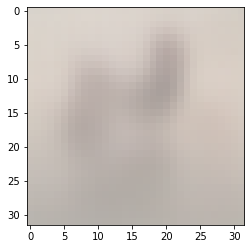

In [61]:
searchdata= searchdata.view(3,32,32)
imshow(searchdata.view(3,32,32))

You have selected an image of the 0 class
Selected distance type is: Euclidean
tensor([[43925, 33418, 13094,  ..., 38281, 20585, 10449],
        [38024,  3428, 14828,  ..., 20585, 47892, 19615],
        [ 1263, 36940, 23131,  ..., 38281, 10449, 20585],
        ...,
        [20503, 27834,  8740,  ..., 38281, 10449, 20585],
        [37827, 44313,  6351,  ..., 10449, 20585, 19615],
        [35728, 19814, 41337,  ..., 38281, 20585, 10449]])
Selected image


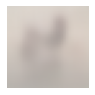

Similar images are:
tensor([[[[[-0.8588, -0.8275, -0.7490,  ..., -0.6863, -0.8039, -0.7961],
           [-0.8431, -0.7961, -0.7569,  ..., -0.7804, -0.7882, -0.7961],
           [-0.8196, -0.7647, -0.7490,  ..., -0.7020, -0.7333, -0.7647],
           ...,
           [-0.5686, -0.4902, -0.4275,  ..., -0.4745, -0.6078, -0.6078],
           [-0.5686, -0.4980, -0.4510,  ..., -0.5137, -0.6157, -0.6157],
           [-0.5608, -0.4980, -0.4902,  ..., -0.5765, -0.6157, -0.6235]],

          [[-0.8667, -0.8353, -0.7569,  ..., -0.6471, -0.7647, -0.7725],
           [-0.8667, -0.8039, -0.7647,  ..., -0.7569, -0.7647, -0.7725],
           [-0.8431, -0.7804, -0.7569,  ..., -0.6863, -0.7176, -0.7490],
           ...,
           [-0.6078, -0.5294, -0.4667,  ..., -0.4980, -0.6314, -0.6235],
           [-0.6078, -0.5373, -0.4902,  ..., -0.5373, -0.6314, -0.6314],
           [-0.6000, -0.5373, -0.5294,  ..., -0.6000, -0.6314, -0.6392]],

          [[-0.8824, -0.8667, -0.7882,  ..., -0.6941, -0.8118, -0.81

RuntimeError: The size of tensor a (3) must match the size of tensor b (32) at non-singleton dimension 2

In [62]:
find_similar_images('Euclidean', searchdata, 0, searchZ, key_embeds=train_embeds)

### How is the algorithm performing on different classes?

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
def similar_group(distance_type, query_img, query_class, query_z, key_embeds, K=25):
    """Finds K closest images to the input image based on euclidean distance between the embedded points """

    if distance_type == 'Euclidean':
      distance = torch.cdist(query_z[None,:], key_embeds[1], p=2)

    if distance_type == 'Cosine':
      cos = nn.CosineSimilarity(dim=1, eps=1e-9)
      distance = cos(query_z[None,:],  key_embeds[1])

    if distance_type == 'Pairwise':
      pair = nn.PairwiseDistance(p =2)
      distance = pair(query_z[None,:],  key_embeds[1])
      
    distance = distance.squeeze(dim=0)
    distance, indices = torch.sort(distance)

    
    input_image = torch.cat([query_img[None]], dim =0)
    index = indices[:K]

    c = []
    for i in index:
      c.append(classes[train_embeds[2][i]])
    count =0
    for i in c:
      if str(i) == query_class:
        count +=1 
    return (count/K)

In [ ]:
def get_accuracy(group, data_loader):
  accuracy =[]
  i=0
  for input,label in data_loader:
    if label == group:
      accuracy.append(similar_group('Euclidean', test_embeds[0][i], classes[test_embeds[2][i]], test_embeds[1][i], key_embeds=train_embeds))
    i+=1
  return accuracy

In [ ]:
accuracies =[]
for i in range(len(classes)): 
  acc = get_accuracy(i,testloader)
  acc_mean = np.mean(np.array(acc))
  accuracies.append(acc_mean)

In [ ]:
y = accuracies
z = range(10)

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(classes):
    ax.annotate(str(txt), (z[i], y[i]))
    plt.ylabel('Ratio of correct similar images')
    plt.xlabel('Classes')

In [ ]:
accuracies

### How does the algorithm perform on rotated images?

### DON'T RUN THIS!!!

In [ ]:
#Flip the images
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [ ]:
batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
train_embeds = embedding(net, trainloader)
test_embeds = embedding(net, testloader)

In [ ]:
accuracies =[]
for i in range(len(classes)): 
  acc = get_accuracy(i,testloader)
  acc_mean = np.median(np.array(acc))
  accuracies.append(acc_mean)

In [ ]:
y = accuracies
z = range(10)

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(classes):
    ax.annotate(str(txt), (z[i], y[i]))
    plt.ylabel('Ratio of correct similar images')
    plt.xlabel('Classes')

In [ ]:
accuracies

### Adding noise to the images

In [ ]:
from skimage.util import random_noise
from torchvision.utils import save_image

In [ ]:
def save_noisy_image(img, name):
    if img.size(1) == 3:
        img = img.view(img.size(0), 3, 32, 32)
        save_image(img, name)
    else:
        img = img.view(img.size(0), 1, 28, 28)
        save_image(img, name)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize data

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
batch_size = 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
def gaussian_noise():
    for data in trainloader:
        img, _ = data[0], data[1]
        gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True))
        save_noisy_image(gauss_img, r"D:\ashishpatel26_github\Pytorch Learning\Noise_image\{dataset}_gaussian.png")        
        break

In [ ]:
def salt_paper_noise():
    for data in trainloader:
        img, _ = data[0], data[1]
        salt_img = torch.tensor(random_noise(img, mode='salt', amount=0.05))
        save_noisy_image(salt_img, r"D:\ashishpatel26_github\Pytorch Learning\Noise_image\{dataset}_salt.png")
        break

In [ ]:
gaussian_noise()

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
train_embeds = embedding(net, trainloader)
test_embeds = embedding(net, testloader)

In [ ]:
accuracies =[]
for i in range(len(classes)): 
  acc = get_accuracy(i,testloader)
  acc_mean = np.median(np.array(acc))
  accuracies.append(acc_mean)

In [ ]:
y = accuracies
z = range(10)

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(classes):
    ax.annotate(str(txt), (z[i], y[i]))
    plt.ylabel('Ratio of correct similar images')
    plt.xlabel('Classes')